In [1]:
%run utils.py
%matplotlib inline
import os.path as osp
import pandas as pd
import numpy as np

In [2]:
df_ds = pd.read_csv(osp.join(FRM_DATA_DIR, 'experiments.csv'))
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 7 columns):
exp_id               692 non-null object
exp_name             692 non-null object
investigators        692 non-null object
researchers          692 non-null object
attachments          288 non-null object
n_fcs_files_total    692 non-null int64
n_fcs_files_parse    692 non-null int64
dtypes: int64(2), object(5)
memory usage: 37.9+ KB


In [3]:
df_chl = pd.read_csv(osp.join(FRM_DATA_DIR, 'fcs_channels_resolved.csv'))

# Fix this Ki67 mapping omission
mask = df_chl['param'] == 'KI67FITC'
df_chl['param'] = df_chl['param'].where(~mask, 'KI67')
df_chl['resolution'] = df_chl['resolution'].where(~mask, 'lookup')
df_chl['term'] = df_chl['resolution'].where(~mask, 'KI67FITC')
# df_chl[df_chl['param'].str.contains('KI67')].groupby(['exp_id', 'param']).size()

df_chl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260161 entries, 0 to 260160
Data columns (total 8 columns):
param_channel    260161 non-null object
param_name       166228 non-null object
filename         260161 non-null object
exp_id           260161 non-null object
term             260161 non-null object
precedence       260161 non-null int64
param            260161 non-null object
resolution       260161 non-null object
dtypes: int64(1), object(7)
memory usage: 15.9+ MB


In [4]:
df_chl.query('resolution == "lookup"').head(1150).tail(15)[['exp_id', 'param_channel', 'param', 'filename']]\
    .rename(columns={'param_channel': 'channel'})

,exp_id,channel,param,filename
2064,FR-FCM-ZZZU,PE-Cy7-A,CD14,0067.FCS
2065,FR-FCM-ZZZU,APC-A,CD11C,0067.FCS
2066,FR-FCM-ZZZU,APC-Cy7-A,IL6,0067.FCS
2068,FR-FCM-ZZZU,Alex 700-A,TNFa,0067.FCS
2069,FR-FCM-ZZZU,Time,Time,0067.FCS
2072,FR-FCM-ZZZU,FITC-A,IFNa,0142.FCS
2073,FR-FCM-ZZZU,PE-A,CD123,0142.FCS
2075,FR-FCM-ZZZU,PE-Cy7-A,CD14,0142.FCS
2076,FR-FCM-ZZZU,APC-A,CD11C,0142.FCS
2077,FR-FCM-ZZZU,APC-Cy7-A,IL6,0142.FCS


In [5]:
df_pr = pd.read_csv(osp.join(DATA_DIR, 'pubmed_abstract_proteins_resolved.csv'))
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61175 entries, 0 to 61174
Data columns (total 8 columns):
id            61175 non-null int64
start         61175 non-null int64
end           61175 non-null int64
value         61175 non-null object
class         61175 non-null object
value_norm    61175 non-null object
value_lbl     61175 non-null object
value_sym     17228 non-null object
dtypes: int64(3), object(5)
memory usage: 3.7+ MB


## Define Target FlowRepository Experiments

In [6]:
exp_ids = list(df_ds[df_ds['exp_name'].str.contains('OMIP')]['exp_id'].unique())
print('Num OMIP datasets found:', len(exp_ids))
exp_ids += [
    'FR-FCM-ZZTJ', # Newell 2016 (Optimization of mass cytometry sample cryopreservation after staining)
    'FR-FCM-ZZTM'  # Newell 2016 (Analysis of lymphocyte composition across human tissues using two mass cytometry panels)
]
df_ds_tgt = df_ds[df_ds['exp_id'].isin(exp_ids)].filter(regex='exp|inves|research')
df_ds_tgt

Num OMIP datasets found: 22


,exp_id,exp_name,investigators,researchers
34,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa
38,FR-FCM-ZZ2T,OMIP-016: Characterization of Antigen-Responsi...,Antonio Cosma,Antonio Cosma
40,FR-FCM-ZZ2V,OMIP-016: Characterization of Antigen-Responsi...,Antonio Cosma,Antonio Cosma
41,FR-FCM-ZZ3Z,OMIP-016: Characterization of Antigen-Responsi...,Antonio Cosma,Antonio Cosma
42,FR-FCM-ZZ3Y,OMIP-016: Characterization of Antigen-Responsi...,Antonio Cosma,Antonio Cosma
45,FR-FCM-ZZ36,OMIP-018: Phenotyping with Chemokine Receptors,Tess Brodie,Tess Brodie
114,FR-FCM-ZZ74,"OMIP-023: 10-Color, 13 antibody panel for in-d...",Attila Tarnok,Jozsef Bocsi
146,FR-FCM-ZZ9H,OMIP-021: Innate-like T-cell Panel,Nicholas Gherardin,Nicholas Gherardin
151,FR-FCM-ZZAZ,OMIP-022: Exemplary Data for comprehensive ass...,Andrew Graves,Andrew Graves
213,FR-FCM-ZZEB,OMIP-024: Pan-leukocyte immunophenotypic chara...,Stephen DeRosa,Gemma Moncunill


In [7]:
df_chl[df_chl['exp_id'].isin(exp_ids)]['resolution'].value_counts()

channel     5391
lookup      4998
original     338
Name: resolution, dtype: int64

## Merge to Parameters

In [8]:
df_chl_ds = pd.merge(df_ds_tgt, df_chl[['exp_id', 'param', 'resolution']], on='exp_id', how='left')
df_chl_ds = df_chl_ds.drop_duplicates()
df_chl_ds = df_chl_ds[df_chl_ds['resolution'] == 'lookup']
df_chl_ds.head()

,exp_id,exp_name,investigators,researchers,param,resolution
0,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,Time,lookup
44,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,CD8,lookup
56,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,CD14,lookup
75,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,CD4,lookup
109,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,CD3,lookup


In [9]:
print(
    'Number of OMIP datasets after param resolution filtering: {}'
    .format(df_chl_ds[df_chl_ds['exp_name'].str.contains('OMIP')]['exp_id'].nunique())
)
print(
    'Number of experiments total after param resolution filtering: {}'
    .format(df_chl_ds['exp_id'].nunique())
)

Number of OMIP datasets after param resolution filtering: 22
Number of experiments total after param resolution filtering: 24


### Mappings

FlowRepository -> Pubmed

In [10]:
fr_prs = df_chl_ds['param'].unique()
fr_prs

array(['Time', 'CD8', 'CD14', 'CD4', 'CD3', 'TNFa', 'IFNG', 'IL4', 'IL2',
       'CD154', 'CD107A', 'CD45RA', 'CD69', 'CD25', 'CD38', 'CD16',
       'CD127', 'CD45', 'FEZF2', 'CD161', 'CD27', 'CD8B', 'CD45RO',
       'TCR-gd', 'TCR', 'CD28', 'CD197', 'IL17A', 'IFNA1', 'IL22', 'TNF',
       'CD19', 'HLADR', 'CD56', 'CD57', 'TCR-Vd2', 'IL21', 'CD185',
       'SNCA', 'CD196', 'CD183', 'CD194', 'CD20', 'CCR10', 'Ki67',
       'CD279', 'CD335', 'DAPI', 'CD159A', 'ADI1', 'GranzymeB', 'KLRG1',
       'CD160', 'CD272', 'CD366', 'GRN', 'CD152', 'STMN1', 'NOC2L',
       'CD223', 'TIGIT', 'CD137', 'Event_length', 'BC', 'MIP', 'CXCL8',
       'CD103', 'CD184', 'INTB7', 'CDW199', 'TCR-Vd1', 'TCR-Va7', 'CD192',
       'IL10', 'CSF2', 'CX3CR1', 'DNA', 'Cisplatin', 'CD29', 'CD62L',
       'CD49A', 'CD186', 'CD278', 'CD95', 'CD31', 'CD49D', 'CD195',
       'IFNg', 'IL17F', 'IL5', 'IL9', 'CD2', 'CD337', 'CD7', 'CD85',
       'CD328', 'CD326', 'CD271', 'CD26', 'IgD', 'IgA', 'CD15', 'IgG',
       'IgM', '

In [11]:
# Search for proteins in the list above not present in pubmed data
np.unique([pr for pr in fr_prs if pr not in df_pr['value_lbl'].unique()])

array(['ADI1', 'BC', 'CD172A', 'CD271', 'CD32', 'CD326', 'CD8B',
       'Cisplatin', 'DAPI', 'DNA', 'Event_length', 'FEZF2', 'GRN',
       'GranzymeB', 'IFNA1', 'IFNG', 'IFNg', 'INTB7', 'Ki67', 'MIP',
       'NOC2L', 'SNCA', 'STMN1', 'TCR-Va7', 'TCR-Vd1', 'TCR-Vd2',
       'TCR-gd', 'TNFa', 'Time'], dtype='<U12')

In [12]:
# df_pr[df_pr['value_lbl'].str.contains('TNF')]['value_lbl'].value_counts()

In [13]:
# Create a map to resolve the above
m_flow_rep = {
    'TCR-Va7': 'Vα7.2',
    'TCR-Vd1': 'Vδ1',
    'TCR-Vd2': 'Vδ2',
    'TCR-gd': 'TCRγδ',
    'INTB7': 'INTEGRINβ7',
    'CD172A': 'SIRPα',
    'CD8B' : 'CD8β',
    'GranzymeB': 'GRZB',
    'IFNg': 'IFNγ',
    'IFNG': 'IFNγ',
    'IFNA1': 'IFNα',
    'Ki67': 'KI67',
    'MIP': 'MIP1β',
    'TNFa': 'TNFα'
}
len(m_flow_rep)

14

In [14]:
# Add a field to be used for join to pubmed protein labels
df_chl_ds['candidate'] = df_chl_ds['param'].apply(lambda v: m_flow_rep.get(v, v))
# Generate mask representing record matches
mask = df_chl_ds['candidate'].isin(df_pr['value_lbl'].unique())

In [15]:
# Check which parameters didn't match (make sure they're not important)
df_chl_ds[~mask]['candidate'].value_counts()

Time            24
Event_length     2
DAPI             2
DNA              2
Cisplatin        2
SNCA             2
BC               2
STMN1            1
NOC2L            1
CD326            1
FEZF2            1
ADI1             1
CD271            1
GRN              1
CD32             1
Name: candidate, dtype: int64

In [16]:
# Check for lost datasets
df_lost = df_chl_ds[~df_chl_ds['exp_id'].isin(df_chl_ds[mask]['exp_id'].unique())]
df_lost = df_lost[['exp_id', 'exp_name']].drop_duplicates()
print('Number of lost datasets:', len(df_lost))
df_lost

Number of lost datasets: 2


,exp_id,exp_name
1378,FR-FCM-ZZ36,OMIP-018: Phenotyping with Chemokine Receptors
3303,FR-FCM-ZZNK,OMIP 026 Manuscript Resub


In [19]:
# At TOW, the 2 datasets above did not label parameters in their FCS files
df_chl[df_chl['exp_id'].isin(df_lost['exp_id'])].groupby(['param', 'resolution']).size()

param              resolution
APC-A              channel       27
APC-Cy7-A          channel       25
Alexa Fluor 405-A  channel       17
Alexa Fluor 430-A  channel       17
Alexa Fluor 488-A  channel       25
Alexa Fluor 700-A  channel        8
BUV395-A           channel        8
BUV737-A           channel       15
BUV800-A           channel       10
BV510-A            channel        8
BV605-A            channel        9
BV711-A            channel        6
BV786-A            channel        9
DAPI               lookup        18
Event #            channel       14
FSC-A              channel       35
FSC-H              channel       20
FSC-W              channel       20
PE-A               channel       23
PE-Alexa 594-A     channel       10
PE-CF594-A         channel        1
PE-Cy5-5-A         channel       17
PE-Cy5-A           channel       17
PE-Cy7-A           channel       30
PE-Texas Red-A     channel       17
PerCP-Cy5-5-A      channel       27
Qdot 605-A         channel       1

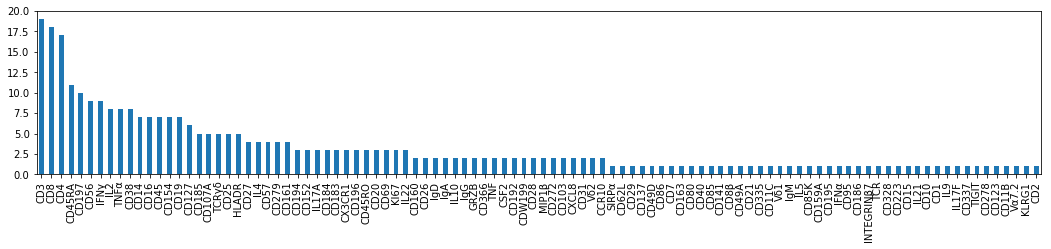

In [20]:
# Check the parameters that did match
df_chl_ds[mask]['candidate'].value_counts().plot(kind='bar', figsize=(18, 3))

In [21]:
df_chl_ds_pm = df_chl_ds[mask].drop(['param', 'resolution'], axis=1).rename(columns={'candidate': 'pr_value_lbl'})
df_chl_ds_pm.head()

,exp_id,exp_name,investigators,researchers,pr_value_lbl
44,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,CD8
56,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,CD14
75,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,CD4
109,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,CD3
148,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,TNFα


## CODEX

In [22]:
pr_codex = [
    'CollagenIV', 'CD7', 'Ki67', 'CD38', 'CD31', 'CD4', 'CD45', 'CD90', 'CD19', 'CD15', 
    'CD3', 'CD104', 'CD21', 'CD34', 'CD278', 'HLADR', 'CD22', 'CD279', 'CD8', 'CD40', 
    'cytokeratin', 'CD9', 'Podoplanin', 'CD11c'
]

# Summarize presence of CODEX markers in FlowRepository and PubMed data
pd.DataFrame([
    (
        pr.upper(), 
        pr.upper() in df_chl_ds_pm['pr_value_lbl'].values, 
        pr.upper() in df_chl['param'].values,
        pr.upper() in df_pr['value_lbl'].values
    )
    for pr in pr_codex
], columns=['pr_value_lbl', 'in_fr_primary', 'in_any_fr', 'in_pubmed'])

,pr_value_lbl,in_fr_primary,in_any_fr,in_pubmed
0,COLLAGENIV,False,False,True
1,CD7,True,True,True
2,KI67,True,True,True
3,CD38,True,True,True
4,CD31,True,True,True
5,CD4,True,True,True
6,CD45,True,True,True
7,CD90,False,True,True
8,CD19,True,True,True
9,CD15,True,True,True


In [23]:
df_chl_ds_pm.head()

,exp_id,exp_name,investigators,researchers,pr_value_lbl
44,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,CD8
56,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,CD14
75,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,CD4
109,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,CD3
148,FR-FCM-ZZ2L,OMIP-014: 12-color HVTN ICS assay,Stephen DeRosa,Stephen DeRosa,TNFα


In [24]:
df_chl_ds_pm_cx = pd.concat([
    df_chl_ds_pm,
    pd.DataFrame([
        dict(exp_id='CODEXH01', exp_name='CODEX Human Panel 01', pr_value_lbl=pr.upper().strip())
        for pr in pr_codex
    ])
], sort=True)[df_chl_ds_pm.columns.tolist()].reset_index(drop=True)
assert len(df_chl_ds_pm_cx[df_chl_ds_pm_cx['exp_id']=='CODEXH01']) == len(pr_codex)
df_chl_ds_pm_cx.tail()

,exp_id,exp_name,investigators,researchers,pr_value_lbl
342,CODEXH01,CODEX Human Panel 01,NaN,NaN,CD40
343,CODEXH01,CODEX Human Panel 01,NaN,NaN,CYTOKERATIN
344,CODEXH01,CODEX Human Panel 01,NaN,NaN,CD9
345,CODEXH01,CODEX Human Panel 01,NaN,NaN,PODOPLANIN
346,CODEXH01,CODEX Human Panel 01,NaN,NaN,CD11C


## Add Experiment/Dataset Label and Type

In [25]:
def get_label(exp_id, exp_name):
    if exp_name.startswith('OMIP'):
        return exp_name.split(':')[0].replace('-', ':')
    if exp_id in ['FR-FCM-ZZTJ', 'FR-FCM-ZZTM']: # Data from Wong et al Immunity  2016
        return 'CYTOF:{}'.format(exp_id)
    if 'CODEX' in exp_id:
        return exp_id.replace('CODEX', 'CODEX:')
    return None

def get_type(exp_id, exp_name):
    if exp_name.startswith('OMIP'):
        return 'OMIP'
    if exp_id in ['FR-FCM-ZZTJ', 'FR-FCM-ZZTM']: # Data from Wong et al Immunity  2016
        return 'CYTOF'
    if 'CODEX' in exp_id:
        return 'CODEX'
    return None

df_chl_ds_pm_cx['exp_lbl'] = [get_label(r['exp_id'], r['exp_name']) for i, r in df_chl_ds_pm_cx.iterrows()]
df_chl_ds_pm_cx['exp_typ'] = [get_type(r['exp_id'], r['exp_name']) for i, r in df_chl_ds_pm_cx.iterrows()]
assert df_chl_ds_pm_cx['exp_lbl'].notnull().all()
assert df_chl_ds_pm_cx['exp_typ'].notnull().all()
df_chl_ds_pm_cx['exp_lbl'].unique()

array(['OMIP:014', 'OMIP:016', 'OMIP:023', 'OMIP:021', 'OMIP:022',
       'OMIP:024', 'OMIP:025', 'OMIP:030', 'OMIP:028', 'OMIP:035',
       'OMIP:036', 'OMIP:037', 'CYTOF:FR-FCM-ZZTJ', 'CYTOF:FR-FCM-ZZTM',
       'OMIP:039', 'OMIP:040', 'OMIP:043', 'OMIP:044', 'OMIP:047',
       'CODEX:H01'], dtype=object)

In [26]:
# Show any experiments where the label is the same across multiple ids (OMIP 16 was the only one at TOW)
df_chl_ds_pm_cx[['exp_id', 'exp_lbl', 'exp_typ']].drop_duplicates()\
    .groupby(['exp_lbl', 'exp_typ'])\
    .apply(lambda g: pd.Series(dict(ids=g['exp_id'].str.cat(sep='|'), n=len(g))))\
    .reset_index().query('n > 1')

,exp_lbl,exp_typ,ids,n
4,OMIP:016,OMIP,FR-FCM-ZZ2T|FR-FCM-ZZ2V|FR-FCM-ZZ3Z|FR-FCM-ZZ3Y,4


In [27]:
df_chl_ds_pm_cx[['exp_id', 'exp_lbl', 'exp_typ']].drop_duplicates()['exp_typ'].value_counts()

OMIP     20
CYTOF     2
CODEX     1
Name: exp_typ, dtype: int64

In [28]:
df_chl_ds_pm_cx['exp_lbl'].value_counts().sort_values()

OMIP:040              3
OMIP:039              9
OMIP:023              9
OMIP:043              9
OMIP:014             10
OMIP:028             10
OMIP:022             12
OMIP:021             12
OMIP:037             12
OMIP:035             12
OMIP:025             13
OMIP:047             13
OMIP:036             16
OMIP:030             16
OMIP:024             16
CODEX:H01            24
OMIP:044             26
OMIP:016             30
CYTOF:FR-FCM-ZZTJ    41
CYTOF:FR-FCM-ZZTM    54
Name: exp_lbl, dtype: int64

## Export

In [29]:
df_chl_ds_pm_cx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 7 columns):
exp_id           347 non-null object
exp_name         347 non-null object
investigators    323 non-null object
researchers      323 non-null object
pr_value_lbl     347 non-null object
exp_lbl          347 non-null object
exp_typ          347 non-null object
dtypes: object(7)
memory usage: 19.1+ KB


In [30]:
path = osp.join(DATA_DIR, 'pubmed_flowrepo_protein_annotations.csv')
df_chl_ds_pm_cx.to_csv(path, index=False)
path

'data/pubmed_flowrepo_protein_annotations.csv'